# osu! Beatmap Validation
**Contributors:** Justin Kaufman, Gilbert Neuner, Marco Scialanga

## Imports
**Most important packages:** Pymongo, Pandas, Numpy (we could also write something else here).

In [1]:
import sys
sys.path.append('../..')
from config import client
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import requests

## Connection with Compass
**Dataset:** osu_random_db, osu_top_db

In [2]:
db = client['osu_top_db']
scores = db.osu_scores_high
count = db.osu_user_beatmap_playcount
players = db.osu_user_stats
scores.create_index("user_id")
random = client['osu_random_db']
maps = random.osu_beatmaps

## Data Retrieval
**Collection:** osu_scores_high

In [3]:
# get list of user_ids
l = list(players.find({}, {"user_id": True}))
user_id = [d['_id'] for d in l]
fifth = user_id[0:-1:4]

In [4]:
# created index for the collection to make the loop quicker
top_scores = []
for i in fifth: 
    beatmaps = list(scores.find({"user_id": i}, {"user_id": True, "pp": True, "beatmap_id": True})) 
    top_scores.append(beatmaps)
df = pd.DataFrame(list(chain.from_iterable(top_scores)))
df.head(20)

,_id,beatmap_id,user_id,pp
0,143686022,55,16622,22.36550
1,242307772,80,16622,46.42990
2,3871154,86,16622,11.41700
3,3624166,87,16622,16.98950
4,3624289,88,16622,16.44250
5,143678052,91,16622,6.50718
6,143646984,100,16622,15.56310
7,143659160,101,16622,26.18790
8,143706131,102,16622,13.21790
9,143708445,103,16622,24.76720


## Data frame with how many times beatmap appears in a players top 15 scores (frequency)

In [5]:
df_top = df.sort_values(['user_id','pp'], ascending = [True, False]).groupby("user_id").head(15)
df_top = df_top.reset_index(drop = True)
df_top = df_top.drop(["_id"], axis = 1)
maps_dict = df_top['beatmap_id'].value_counts().to_dict()
temp = pd.DataFrame.from_dict(maps_dict, orient = "index").reset_index()
temp = temp.rename(columns = {"index": "beatmap_id"})
df_top = df_top.merge(temp, how = "left")
df_top = df_top.rename(columns = {0: "frequency_top_fifteen"})
df_top.head(10)

,beatmap_id,user_id,pp,frequency_top_fifteen
0,946082,16622,408.585,145
1,793846,16622,401.385,29
2,740044,16622,401.163,79
3,888010,16622,392.790,195
4,1090928,16622,388.155,52
5,795627,16622,387.120,35
6,759192,16622,386.262,10
7,588975,16622,385.945,2
8,827803,16622,384.567,120
9,795810,16622,383.438,43


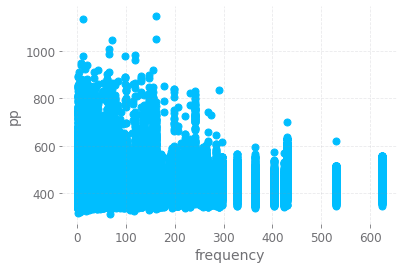

In [32]:
plt.xlabel("frequency")
plt.ylabel("pp")
plt.scatter(df_top["frequency_top_fifteen"], df_top["pp"])

In [6]:
maps_dict_total = df['beatmap_id'].value_counts().to_dict()
temp_total = pd.DataFrame.from_dict(maps_dict_total, orient = "index").reset_index()
temp_total = temp_total.rename(columns = {"index": "beatmap_id"})
df_top = df_top.merge(temp_total, how = "left")
df_top.head(10)
#merge how many times the beatmap occurs in the dataframe

,beatmap_id,user_id,pp,frequency_top_fifteen,0
0,946082,16622,408.585,145,1610
1,793846,16622,401.385,29,834
2,740044,16622,401.163,79,867
3,888010,16622,392.790,195,2270
4,1090928,16622,388.155,52,1459
5,795627,16622,387.120,35,3950
6,759192,16622,386.262,10,1891
7,588975,16622,385.945,2,677
8,827803,16622,384.567,120,3338
9,795810,16622,383.438,43,2565


(array([17107.,  7372.,  4292.,  2906.,  2719.,   692.,  1257.,     0.,
          531.,   624.]),
 array([  1. ,  63.3, 125.6, 187.9, 250.2, 312.5, 374.8, 437.1, 499.4,
        561.7, 624. ]),
 <BarContainer object of 10 artists>)

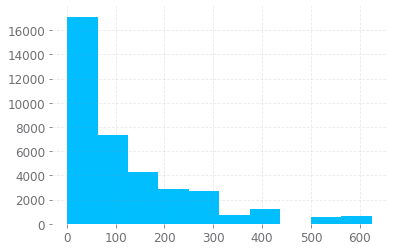

In [7]:
plt.hist(df_top["frequency_top_fifteen"])

### Create a ratio of how many times a beatmap appeared in a players top 15 / how many times it occured in the dataset total

In [8]:
df_top = df_top.rename(columns = {0: "frequency_total"})
df_top["ratio"] = np.divide(df_top["frequency_top_fifteen"], df_top["frequency_total"])
df_top.head(20)
#create a ratio that represents frequency_top_ten/frequency_total

,beatmap_id,user_id,pp,frequency_top_fifteen,frequency_total,ratio
0,946082,16622,408.585,145,1610,0.090062
1,793846,16622,401.385,29,834,0.034772
2,740044,16622,401.163,79,867,0.091119
3,888010,16622,392.790,195,2270,0.085903
4,1090928,16622,388.155,52,1459,0.035641
5,795627,16622,387.120,35,3950,0.008861
6,759192,16622,386.262,10,1891,0.005288
7,588975,16622,385.945,2,677,0.002954
8,827803,16622,384.567,120,3338,0.035950
9,795810,16622,383.438,43,2565,0.016764


In [9]:
df_top[df_top["ratio"] == max(df_top["ratio"])]

,beatmap_id,user_id,pp,frequency_top_fifteen,frequency_total,ratio
92,1754777,137441,527.033,242,946,0.255814
218,1754777,371961,501.405,242,946,0.255814
527,1754777,629717,560.792,242,946,0.255814
625,1754777,684433,480.554,242,946,0.255814
681,1754777,754565,770.339,242,946,0.255814
...,...,...,...,...,...,...
35528,1754777,13229402,447.560,242,946,0.255814
35670,1754777,13331114,520.878,242,946,0.255814
35985,1754777,13628898,486.886,242,946,0.255814
36390,1754777,14083038,469.035,242,946,0.255814


In [10]:
df_top[df_top["frequency_top_fifteen"] == max(df_top["frequency_top_fifteen"])]

,beatmap_id,user_id,pp,frequency_top_fifteen,frequency_total,ratio
138,2118443,243917,420.758,624,3250,0.192
181,2118443,343865,524.852,624,3250,0.192
222,2118443,371961,481.830,624,3250,0.192
755,2118443,822003,475.864,624,3250,0.192
901,2118443,977133,424.660,624,3250,0.192
...,...,...,...,...,...,...
37185,2118443,15216246,481.830,624,3250,0.192
37290,2118443,15526534,505.862,624,3250,0.192
37414,2118443,16327582,460.325,624,3250,0.192
37446,2118443,16593233,422.445,624,3250,0.192


(array([11775.,  9164.,  5485.,  3470.,  2849.,  1552.,  1147.,  1250.,
          513.,   295.]),
 array([1.64015089e-04, 2.57290089e-02, 5.12940028e-02, 7.68589966e-02,
        1.02423990e-01, 1.27988984e-01, 1.53553978e-01, 1.79118972e-01,
        2.04683966e-01, 2.30248960e-01, 2.55813953e-01]),
 <BarContainer object of 10 artists>)

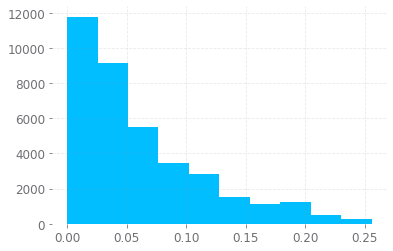

In [11]:
plt.hist(df_top["ratio"])

In [12]:
some_maps = list(df["beatmap_id"])
date = list(maps.find({}, {"_id" : True, "last_update": True}))
df_date = pd.DataFrame(date)
df_date.head(10)

,_id,last_update
0,53,2014-05-18 09:56:27
1,54,2014-05-18 10:13:39
2,55,2014-05-18 09:56:40
3,75,2014-05-18 10:16:42
4,80,2014-05-18 10:21:41
5,86,2014-05-18 10:14:35
6,87,2014-05-18 09:50:40
7,88,2019-11-14 21:13:21
8,91,2014-05-18 07:42:34
9,94,2014-05-18 10:22:00


### Create a coefficient for each players top 15 scores, add totalweight column that represents each beatmap summed coefficient

In [13]:
lister=[1,0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.40,0.35,0.30]
lister=lister*2500
df_top["weight"]=pd.Series(lister)
weighted_df=df_top.groupby(["beatmap_id"])["weight"].agg('sum')
weighted_df=pd.DataFrame(weighted_df)
weighted_df=weighted_df.rename(columns = {'weight': 'totalWeight'})
weighted_df=weighted_df.reset_index()
weighted_df

,beatmap_id,totalWeight
0,19015,0.80
1,22077,0.45
2,23414,1.00
3,23484,0.50
4,24233,1.00
...,...,...
2817,2822288,0.50
2818,2847753,0.30
2819,2860521,12.75
2820,2861378,5.10


### Create new column (weightedRatio) that represents the total weight / frequency total

In [14]:
df_top = df_top.merge(weighted_df, how = "left")
df_top["weightedRatio"]=np.divide(df_top['totalWeight'],df_top['frequency_total'])
df_top=df_top.sort_values(by=['weightedRatio'],ascending=False)
df_top

,beatmap_id,user_id,pp,frequency_top_fifteen,frequency_total,ratio,weight,totalWeight,weightedRatio
25621,1754777,9476042,524.546,242,946,0.255814,0.95,201.30,0.212791
24556,1754777,9147909,439.476,242,946,0.255814,0.95,201.30,0.212791
24065,1754777,8982518,479.796,242,946,0.255814,0.75,201.30,0.212791
6394,1754777,3478883,672.820,242,946,0.255814,0.80,201.30,0.212791
32661,1754777,11749789,545.073,242,946,0.255814,0.70,201.30,0.212791
...,...,...,...,...,...,...,...,...,...
23339,741572,8751123,345.631,1,1924,0.000520,0.30,0.30,0.000156
34664,1627157,12703920,355.087,1,2041,0.000490,0.30,0.30,0.000147
13271,1033154,5447229,374.072,1,3334,0.000300,0.45,0.45,0.000135
8504,738063,4118677,342.366,1,2610,0.000383,0.30,0.30,0.000115


In [15]:
len(df_top['beatmap_id'].unique()) # of unique beatmaps

2822

(array([14101., 10227.,  4916.,  2889.,  2171.,  1138.,   820.,   943.,
            0.,   295.]),
 array([8.20075447e-05, 2.13528766e-02, 4.26237456e-02, 6.38946146e-02,
        8.51654836e-02, 1.06436353e-01, 1.27707222e-01, 1.48978091e-01,
        1.70248960e-01, 1.91519829e-01, 2.12790698e-01]),
 <BarContainer object of 10 artists>)

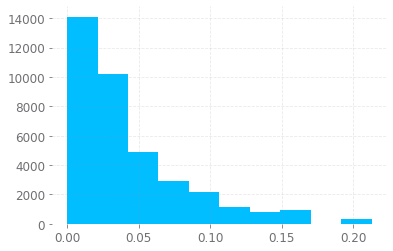

In [16]:
plt.hist(df_top["weightedRatio"])
#there are few beatmaps with high ratios; these beatmaps may indicate overweightness as they occur in a players top 15 frequently

### Correlation Heatmap

### Webscraping for top overweighted maps off of osu-pps.com

In [18]:
osu = pd.read_csv("run_results-12.csv", sep = ";")
osu["selection1_url"] = osu["selection1_url"].str.slice(20)
osu = osu.rename(columns = {"selection1_url": "beatmap_id"})
osu = osu[4200:]
osu = osu.reset_index()
osu

,index,selection1_name,beatmap_id,selection1_selection2
0,4200,MIMI feat. Hatsune Miku - Ai no Sukima [Radiance],1988753,10000
1,4201,Set It Off - Horrible Kids [Kuki's Extra],2596018,8622
2,4202,S3RL - Bass Slut (Original Mix) [Reform's Filt...,2118443,8482
3,4203,DM DOKURO - SAVE (Encore) [Reform's Extra],2964222,6705
4,4204,Nogizaka46 - Yubi Bouenkyou (TV Size) [Fate],2469345,6381
...,...,...,...,...
415,4615,yuikonnu - Yume Chizu [Dream],2237466,375
416,4616,S3RL - Bass Slut (Original Mix) [TheShadow's D...,2118445,374
417,4617,Nogizaka46 - Yubi Bouenkyou (TV Size) [Glaceon...,2469346,374
418,4618,MIMI feat. Hatsune Miku - Ai no Sukima [Insane],1988750,372


In [19]:
a = [str(i) for i in df_top['beatmap_id']]
m = set(a)
n = set(osu["beatmap_id"])
inter = list(m.intersection(n))
b = [int(i) for i in inter]

### Find overlapping overweighted beatmaps in our data and osu-pps data

In [20]:
new_df = df_top[df_top["beatmap_id"].isin(b)]
rankings = new_df[["beatmap_id","weightedRatio"]]
rankings = rankings.drop_duplicates()
rankings = rankings.reset_index(drop = True)
rankings

,beatmap_id,weightedRatio
0,1754777,0.212791
1,2111505,0.193409
2,2587891,0.160420
3,2659911,0.157904
4,2596018,0.156681
...,...,...
240,1091249,0.000248
241,1612453,0.000164
242,1627157,0.000147
243,1033154,0.000135


In [21]:
rankings["beatmap_id"] = rankings["beatmap_id"].astype('int')
osu["beatmap_id"] = osu["beatmap_id"].astype('int')
rankings = rankings.merge(osu, how = "left")
rankings = rankings.drop(["index"], axis = 1)

In [22]:
rankings

,beatmap_id,weightedRatio,selection1_name,selection1_selection2
0,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3985
1,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3136
2,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],2718
3,2111505,0.193409,VINXIS - Sidetracked Day [Sojourn Collab],1556
4,2587891,0.160420,chano & 40mP - Natsukoi Hanabi (Sped Up Ver.) ...,3645
...,...,...,...,...
365,1091249,0.000248,RADWIMPS - Zen Zen Zense (movie ver.) [Extra: ...,467
366,1612453,0.000164,Icon For Hire - Make a Move (Speed Up Ver.) [C...,574
367,1627157,0.000147,Icon For Hire - Make a Move (Speed Up Ver.) [L...,903
368,1033154,0.000135,9mm Parabellum Bullet - Inferno [Agonizing Ins...,415


## Correlation between our overweighted maps and osu-pps.com overweighted maps

In [23]:
rankings = rankings.rename(columns = {"selection1_selection2": "website_score"})
rankings['weightedRatio'].corr(rankings["website_score"])

0.34420436032784013

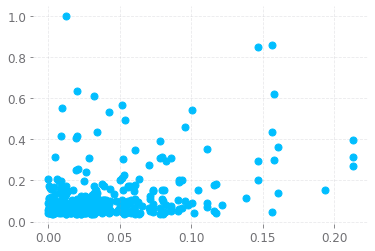

In [24]:
plt.scatter(rankings["weightedRatio"], rankings["website_score"]/10000)

In [25]:
rankings["our-ranking"] = np.arange(1,371,1)
rankings

,beatmap_id,weightedRatio,selection1_name,website_score,our-ranking
0,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3985,1
1,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3136,2
2,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],2718,3
3,2111505,0.193409,VINXIS - Sidetracked Day [Sojourn Collab],1556,4
4,2587891,0.160420,chano & 40mP - Natsukoi Hanabi (Sped Up Ver.) ...,3645,5
...,...,...,...,...,...
365,1091249,0.000248,RADWIMPS - Zen Zen Zense (movie ver.) [Extra: ...,467,366
366,1612453,0.000164,Icon For Hire - Make a Move (Speed Up Ver.) [C...,574,367
367,1627157,0.000147,Icon For Hire - Make a Move (Speed Up Ver.) [L...,903,368
368,1033154,0.000135,9mm Parabellum Bullet - Inferno [Agonizing Ins...,415,369


In [26]:
rankings = rankings.sort_values(by = "website_score", ascending = False)
rankings["osu-ranking"] = np.arange(1,371,1)
rankings

,beatmap_id,weightedRatio,selection1_name,website_score,our-ranking,osu-ranking
263,1988753,0.012522,MIMI feat. Hatsune Miku - Ai no Sukima [Radiance],10000,264,1
8,2596018,0.156681,Set It Off - Horrible Kids [Kuki's Extra],8622,9,2
11,2118443,0.146785,S3RL - Bass Slut (Original Mix) [Reform's Filt...,8482,12,3
224,2469345,0.019918,Nogizaka46 - Yubi Bouenkyou (TV Size) [Fate],6381,225,4
6,2659911,0.157904,EDOGA-SULLIVAN - WONDERFUL WONDER (TV Size) [S...,6204,7,5
...,...,...,...,...,...,...
341,1749322,0.002446,Simple Plan - You Suck At Love (Speed Up Ver.)...,376,342,366
269,2237466,0.012296,yuikonnu - Yume Chizu [Dream],375,270,367
98,2469346,0.052683,Nogizaka46 - Yubi Bouenkyou (TV Size) [Glaceon...,374,99,368
272,2118445,0.012146,S3RL - Bass Slut (Original Mix) [TheShadow's D...,374,273,369


In [28]:
rankings = rankings.sort_values(by = "our-ranking", ascending = True)

In [29]:
rankings = rankings.rename(columns = {"selection1_name": "beatmap", "weightedRatio": "weighted_ratio", 
                                      "our-ranking": "our_ranking", "osu-ranking":"osu_ranking"})
rankings

,beatmap_id,weighted_ratio,beatmap,website_score,our_ranking,osu_ranking
0,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3985,1,18
1,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3136,2,25
2,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],2718,3,34
3,2111505,0.193409,VINXIS - Sidetracked Day [Sojourn Collab],1556,4,68
4,2587891,0.160420,chano & 40mP - Natsukoi Hanabi (Sped Up Ver.) ...,3645,5,20
...,...,...,...,...,...,...
365,1091249,0.000248,RADWIMPS - Zen Zen Zense (movie ver.) [Extra: ...,467,366,308
366,1612453,0.000164,Icon For Hire - Make a Move (Speed Up Ver.) [C...,574,367,254
367,1627157,0.000147,Icon For Hire - Make a Move (Speed Up Ver.) [L...,903,368,151
368,1033154,0.000135,9mm Parabellum Bullet - Inferno [Agonizing Ins...,415,369,339


In [30]:
rankings = rankings.rename(columns = {"osu_ranking": "website_ranking"})
rankings

,beatmap_id,weighted_ratio,beatmap,website_score,our_ranking,website_ranking
0,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3985,1,18
1,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],3136,2,25
2,1754777,0.212791,VINXIS - Sidetracked Day [Infinity Inside],2718,3,34
3,2111505,0.193409,VINXIS - Sidetracked Day [Sojourn Collab],1556,4,68
4,2587891,0.160420,chano & 40mP - Natsukoi Hanabi (Sped Up Ver.) ...,3645,5,20
...,...,...,...,...,...,...
365,1091249,0.000248,RADWIMPS - Zen Zen Zense (movie ver.) [Extra: ...,467,366,308
366,1612453,0.000164,Icon For Hire - Make a Move (Speed Up Ver.) [C...,574,367,254
367,1627157,0.000147,Icon For Hire - Make a Move (Speed Up Ver.) [L...,903,368,151
368,1033154,0.000135,9mm Parabellum Bullet - Inferno [Agonizing Ins...,415,369,339
